# Customer Churn Prediction Model

Customer churn prediction is an important challenge for businesses, particularly in the telecom sector. It focuses on identifying customers who are likely to discontinue their service. With these insights, companies can take proactive measures to engage at-risk customers, improve satisfaction, and reduce potential revenue loss.

## Data Import and Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv("/Users/madhulika/Downloads/customer_churn_prediction.csv")

## Exploratory Data Analysis

In [3]:
df.shape

(7043, 21)

In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Since the TotalCharges column had gaps and non-numeric values, I will be handling them and cast the column into numeric form.

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


## Data Exploration & Visualization

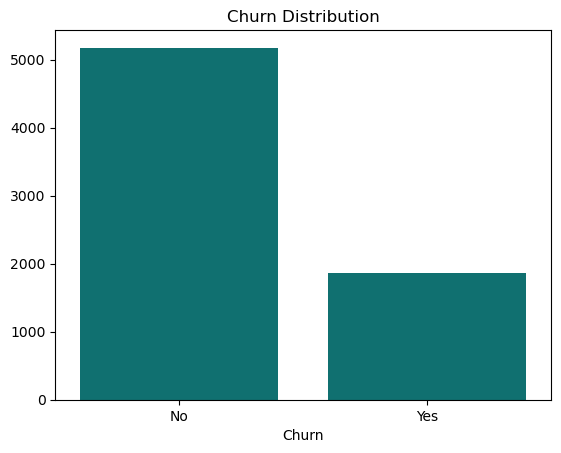

In [7]:
churn_count = df['Churn'].value_counts()
sns.barplot(x=churn_count.index, y=churn_count.values, color='teal')
plt.title('Churn Distribution')
plt.show()

Visualizing correlations between numerical features (tenure, MonthlyCharges, and TotalCharges) helps uncover relationships and patterns in customer behavior.

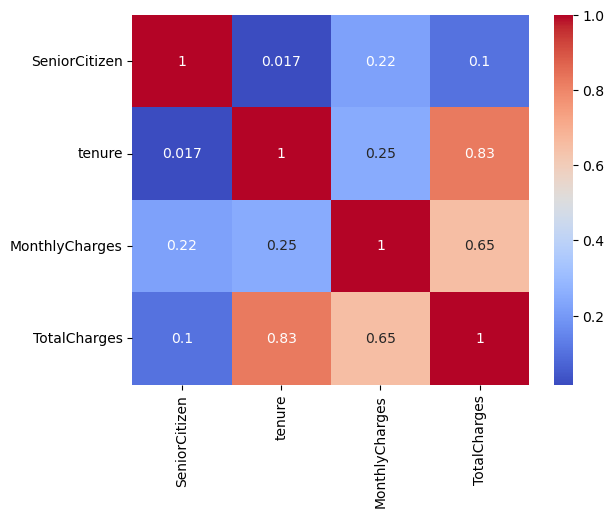

In [8]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

## Encoding Categorical Variables

### i) Converting binary columns with Label Encoding

Binary columns (like Yes/No or Male/Female) can be directly converted into 0s and 1s. Here, we use LabelEncoder to transform them.

In [9]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

### ii) One-Hot Encoding for categorical variables

For categorical features with more than two categories (e.g., Contract, InternetService, PaymentMethod), we use one-hot encoding. This creates separate binary columns for each category, ensuring the model can interpret them correctly.

In [10]:
cat_cols = ['Contract', 'InternetService', 'PaymentMethod']
df = pd.get_dummies(df, columns=cat_cols)

Finally, I scaled the numerical features so they share the same range and no single variable dominates the models due to its scale.

In [11]:
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.994194
1,0.066327,-0.259629,-0.173740
2,-1.236724,-0.362660,-0.959649
3,0.514251,-0.746535,-0.195248
4,-1.236724,0.197365,-0.940457


## Building the Prediction Model

I selected a Decision Tree Classifier for building the prediction model because it provides clear interpretability, handles both categorical and numerical data without requiring heavy preprocessing, and captures non-linear relationships between features and the target. By setting the maximum depth to 6, the model maintains good predictive performance while avoiding overfitting.

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Drop ID customer ID if present
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

# Convert categorical columns into numeric with one-hot encoding
df = pd.get_dummies(df)

# Split features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Decision Tree
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print("Model trained successfully!")

Model trained successfully!


### Model Evaluation

After training the model, I assessed its performance using a classification report and a confusion matrix. These metrics provide a clear view of how accurately the model predicts churn, highlighting precision, recall, F1-score, and where misclassifications occur.


In [14]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.66      0.53      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



#### Confusion Matrix

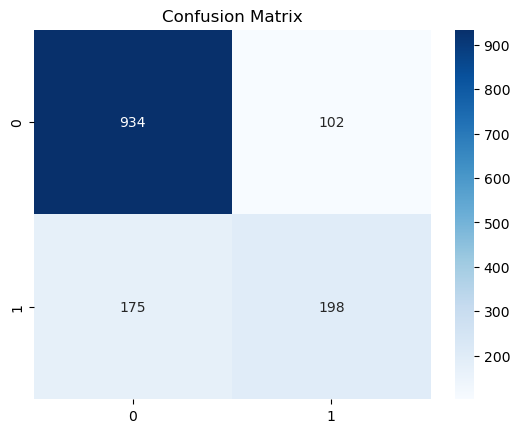

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that the model is strong at identifying non-churn customers but struggles more with correctly identifying churners. While it correctly classified 934 non-churners and 198 churners, it also missed 175 churners (false negatives). This indicates the model favors the majority class, and improving recall for churn prediction should be a focus in the next steps.

### Main Contributing Features

I will create a DataFrame that pairs each feature with its importance score from the trained model. Then I will sort these scores in descending order so the most influential predictors appear at the top.


In [16]:
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

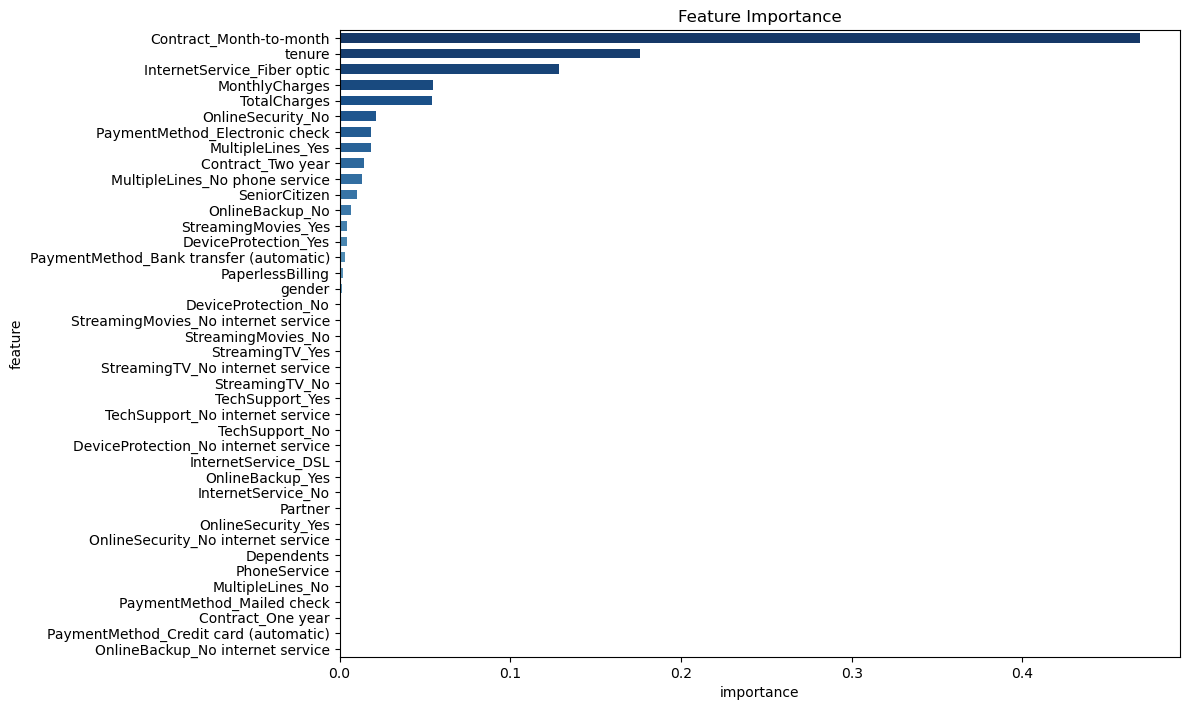

In [20]:
plt.figure(figsize=(12,7))
sns.barplot(
    data=importance,
    x='importance',
    y='feature',
    hue='feature',      
    palette='Blues_r',
    width=0.6
)
plt.tight_layout()
plt.title('Feature Importance')
plt.show()

The plot shows the relative importance of features in predicting churn. Features with higher scores have more influence on the model’s decision.

• Contract type and tenure stand out as the strongest predictors, meaning customer commitment level and length of relationship play a major role in churn.

• Monthly charges and payment method also contribute significantly, suggesting that billing structure and payment preferences affect churn likelihood.

•	Other features have smaller importance scores, indicating that while they add some predictive value, they don’t drive churn as strongly.
This analysis helps focus retention strategies on the top drivers rather than spreading efforts across all features equally.

### Predicting Outcomes

For a new customer, I input their data into the trained model to see if they are at risk of churning.

In [21]:
customer = {
    'tenure': 12,
    'MonthlyCharges': 90.45,
    'TotalCharges': 1085.40, 
    'Contract': 'Month-to-month',
    'InternetService': 'Fiber optic',
    'PaymentMethod': 'Electronic check'
}

#### Preparing and Scaling Data Before Prediction

In [22]:
def prepare_data(new_df, X_train, num_cols, scaler):
    # One-hot encode categorical features
    new_df = pd.get_dummies(new_df)

    # Align with training features
    new_df = new_df.reindex(columns=X_train.columns, fill_value=0)

    # Scale numeric columns using the fitted scaler
    new_df[num_cols] = scaler.transform(new_df[num_cols])

    return new_df

In [23]:
customer_df = pd.DataFrame([customer])
prepared_data = prepare_data(customer_df, X_train, ['tenure','MonthlyCharges','TotalCharges'], scaler)
prediction = model.predict(prepared_data)[0]
probability = model.predict_proba(prepared_data)[0]

In [24]:
print("Prediction:", prediction) 
print("Probabilities:", probability)      
print("Churn probability:", probability[1]) 

Prediction: 1
Probabilities: [0.39108911 0.60891089]
Churn probability: 0.6089108910891089


### Conclusion

The prediction indicates that the model leans toward churn, but with only moderate confidence at around 61%, meaning the outcome is not overwhelmingly certain. From a business perspective, this suggests the customer is at risk and may benefit from targeted retention efforts such as offers, personalized follow-ups, or service adjustments. When applied across a broader customer base, probabilities like these help prioritize which customers should be the focus of intervention, with higher churn probabilities pointing to the most critical cases.